# Data Exploration

In this notebook we will explore some features of the dataset with focus on QA.

At this point I'll add the bias of work with 3 different possibilities (without considering expand the dataset and remodelling the problem):

1. Extractive QA: The answer is a span of text from the context.
    1. In this case we can possible use some kind of retriever in the query and use the model as an extractor for the context. 
    2. The problem with this (at this point) is don't know how good each topic of the dataset is represented in the dataset.
2. Open Generative QA: The answer generated by one of the retrieved options.
    1. Using more complexity (in terms of memory and time) we can use a model to generate the answer. We rely in some pre-trained model knowledge better approach some queries variants.
    2. More complexity, more inference time, possible need GPU and not can generate no safety answer (considering the dataset is composed only by true/safe answers).
3. Generative QA: The answer is a free text.
    1. The same as the open generative QA but not always rely in the retrieved options.


## Libs and Variables

In [30]:
import random
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import tiktoken
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
from wordllama import WordLlama
from wordllama.inference import WordLlamaInference

nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Matheus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
def seed_all():
    """
    Seed all the random number generators to ensure reproducibility.

    This function sets the seed for the Python built-in random module and the NumPy random module to 42.
    This ensures that any random operations performed using these modules will produce the same results
    each time the code is run.
    """
    random.seed(42)
    np.random.seed(42)


seed_all()

In [32]:
DATA_PATH = "../data/data.csv"

## Load data

In [33]:
data = pd.read_csv(DATA_PATH)

data["question"] = data["question"].astype(str)
data["answer"] = data["answer"].astype(str)

In [34]:
data.sample(5).style

,question,answer
3634,Is Juvenile Huntington disease inherited ?,"How is Juvenile Huntington disease (HD) inherited? Juvenile HD is inherited in an autosomal dominant manner, which means that one copy of the altered gene in each cell is sufficient to cause the disorder. An affected person usually inherits the altered gene from one affected parent. As the altered HTT gene is passed from one generation to the next, the size of the CAG trinucleotide repeat often increases in size. A larger number of repeats is usually associated with an earlier onset of signs and symptoms (anticipation). A larger number of repeats is usually associated with an earlier onset of signs and symptoms. Most often, children with juvenile HD inherit the expanded CAG trinucleotide repeat from their fathers, although on occasion they inherit it from their mothers."
13745,What are the treatments for nemaline myopathy ?,These resources address the diagnosis or management of nemaline myopathy: - Gene Review: Gene Review: Nemaline Myopathy - Genetic Testing Registry: Nemaline myopathy - Genetic Testing Registry: Nemaline myopathy 1 - Genetic Testing Registry: Nemaline myopathy 10 - Genetic Testing Registry: Nemaline myopathy 2 - Genetic Testing Registry: Nemaline myopathy 3 - Genetic Testing Registry: Nemaline myopathy 4 - Genetic Testing Registry: Nemaline myopathy 5 - Genetic Testing Registry: Nemaline myopathy 6 - Genetic Testing Registry: Nemaline myopathy 7 - Genetic Testing Registry: Nemaline myopathy 8 - Genetic Testing Registry: Nemaline myopathy 9 These resources from MedlinePlus offer information about the diagnosis and management of various health conditions: - Diagnostic Tests - Drug Therapy - Surgery and Rehabilitation - Genetic Counseling - Palliative Care
4395,What is (are) Hailey-Hailey disease ?,"Hailey-Hailey disease is a hereditary blistering skin disease. Signs and symptoms include a painful rash and blistering in skin folds such as the armpits, groin, neck, under the breasts, and between the buttocks. Secondary bacterial infections are not uncommon. Symptoms are often worse in summer months due to heat, sweating and friction. Hailey-Hailey disease is caused by mutations in the ATP2C1 gene and is inherited in an autosomal dominant manner. Treatment focuses on reducing symptoms and preventing flares."
10274,Is transthyretin amyloidosis inherited ?,"This condition is inherited in an autosomal dominant pattern, which means one copy of the altered gene in each cell is sufficient to cause the disorder. In most cases, an affected person inherits the mutation from one affected parent. Rarely, cases result from new mutations in the gene and occur in people with no history of the disorder in their family. Not all people who have a TTR gene mutation will develop transthyretin amyloidosis."
149,How many people are affected by Balance Problems ?,"In 2008, an estimated 14.8 percent of American adults (33.4 million) had a balance or dizziness problem during the past year. See statistics about the frequency of balance and other sensory impairments in older adults. (Centers for Disease Control and Prevention)"


## Data analysis

In [35]:
data.shape[0], data["question"].nunique()

(16406, 14981)

## Token number analysis

In [36]:
# I'll use the tiktoken as pattern tokenizer (easy, fast and near to other BPE's based tokenizers)
tokenizer = tiktoken.get_encoding("o200k_base")

In [37]:
data["question_n_tokens"] = data["question"].apply(lambda x: len(tokenizer.encode(x)))
data["answer_n_tokens"] = data["answer"].apply(lambda x: len(tokenizer.encode(x)))

In [38]:
data["question_n_tokens"].describe()

count    16406.000000
mean        12.028892
std          3.785987
min          4.000000
25%          9.000000
50%         11.000000
75%         14.000000
max         40.000000
Name: question_n_tokens, dtype: float64

In [39]:
data["answer_n_tokens"].describe()

count    16406.000000
mean       267.114653
std        327.536414
min          1.000000
25%         97.000000
50%        182.000000
75%        327.000000
max       5644.000000
Name: answer_n_tokens, dtype: float64

We can observe the number of tokens in question is really low.

<Axes: title={'center': 'Number of tokens in questions'}, ylabel='Frequency'>

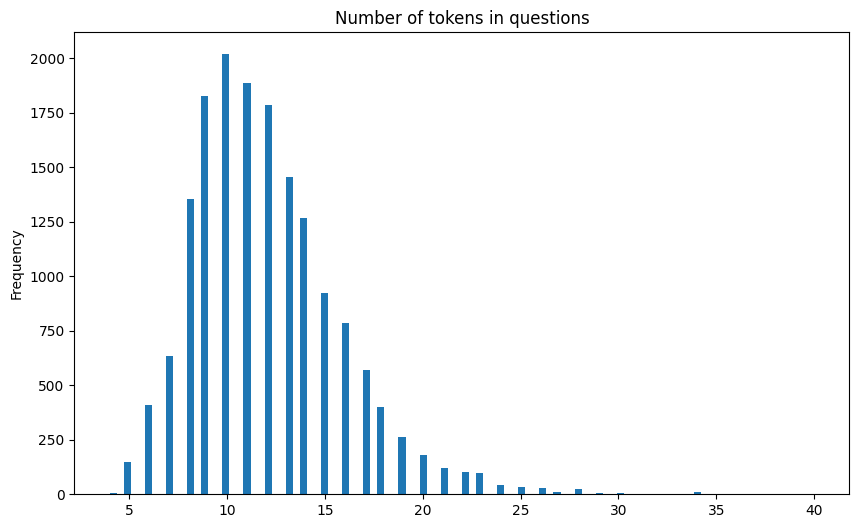

In [40]:
data["question_n_tokens"].plot(
    kind="hist", bins=100, figsize=(10, 6), title="Number of tokens in questions"
)

The number of tokens in answer is high.

That can represent a problem because the query it's based in questions and the volume of information is major based in the answer.

<Axes: title={'center': 'Number of tokens in answers'}, ylabel='Frequency'>

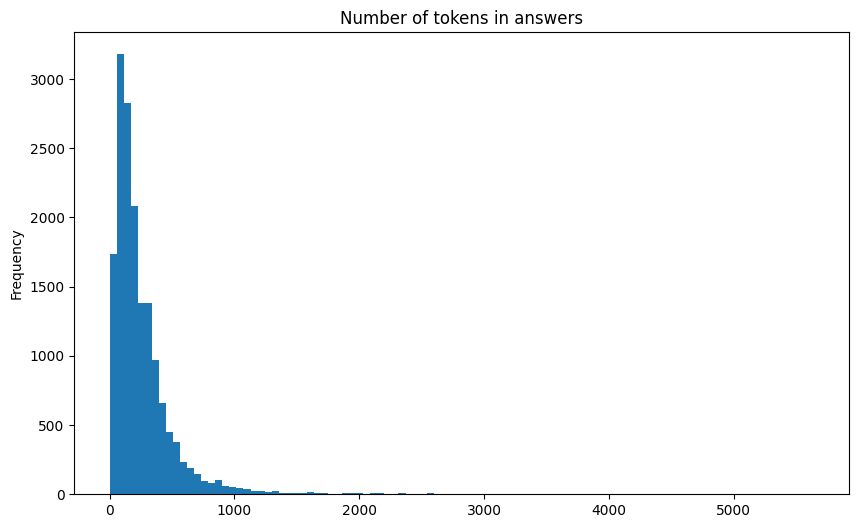

In [41]:
data["answer_n_tokens"].plot(
    kind="hist", bins=100, figsize=(10, 6), title="Number of tokens in answers"
)

## Clustering analysis

### Preprocessing question column

In [42]:
# Lowercase
data["question_processed"] = data["question"].str.lower()

# Remove punctuation and parentheses
data["question_processed"] = data["question_processed"].str.replace(
    r"[^a-z0-9\s]", "", regex=True
)

# Tokenize
data["question_processed"] = data["question_processed"].apply(nltk.word_tokenize)

# Remove stopwords
stopwords = set(nltk.corpus.stopwords.words("english"))
data["question_processed"] = data["question_processed"].apply(
    lambda x: [word for word in x if word not in stopwords]
)

In [43]:
data[["question", "question_processed"]].head(5)

,question,question_processed
0,What is (are) Glaucoma ?,[glaucoma]
1,What is (are) Glaucoma ?,[glaucoma]
2,What is (are) Glaucoma ?,[glaucoma]
3,Who is at risk for Glaucoma? ?,"[risk, glaucoma]"
4,How to prevent Glaucoma ?,"[prevent, glaucoma]"


### Identification of need to remove repeated spaces

In [44]:
extracted_text = (
    data.sort_values(by="answer_n_tokens", ascending=False)
    .iloc[0]["answer"]
    .strip()
    .replace("\n", " ")
)

print(extracted_text)

cleaned_text = re.sub(r"\s+", " ", extracted_text).strip()

Key Points                     - There are different types of treatment for patients with breast cancer.    - Five types of standard treatment are used:         - Surgery      - Radiation therapy      - Chemotherapy      - Hormone therapy      - Targeted therapy        - New types of treatment are being tested in clinical trials.          - High-dose chemotherapy with stem cell transplant        - Treatment for breast cancer may cause side effects.    - Patients may want to think about taking part in a clinical trial.    - Patients can enter clinical trials before, during, or after starting their cancer treatment.    - Follow-up tests may be needed.                                                       There are different types of treatment for patients with breast cancer.                     Different types of treatment are available for patients with breast cancer. Some treatments are standard (the currently used treatment), and some are being tested in clinical trials. A treatment c

In [45]:
len(tokenizer.encode(cleaned_text))

5376

In [46]:
cleaned_text

"Key Points - There are different types of treatment for patients with breast cancer. - Five types of standard treatment are used: - Surgery - Radiation therapy - Chemotherapy - Hormone therapy - Targeted therapy - New types of treatment are being tested in clinical trials. - High-dose chemotherapy with stem cell transplant - Treatment for breast cancer may cause side effects. - Patients may want to think about taking part in a clinical trial. - Patients can enter clinical trials before, during, or after starting their cancer treatment. - Follow-up tests may be needed. There are different types of treatment for patients with breast cancer. Different types of treatment are available for patients with breast cancer. Some treatments are standard (the currently used treatment), and some are being tested in clinical trials. A treatment clinical trial is a research study meant to help improve current treatments or obtain information on new treatments for patients with cancer. When clinical t

### Duplicated questions and answers

One question map multiple answers

In [47]:
print(data.shape)
data["question"].unique().shape

(16406, 5)


(14981,)

One answer map multiple questions

In [48]:
print(data.shape)
data["answer"].unique().shape

(16406, 5)


(15812,)

### Analysis of frequency of words


In [49]:
# create a counter (word, count) for each word in data["question_processed"]
word_counts = data["question_processed"].apply(pd.Series).stack().value_counts()

# create a dataframe with the word counts
word_counts = pd.DataFrame(word_counts).reset_index()

# rename the columns
word_counts.columns = ["word", "count"]

<Axes: ylabel='word'>

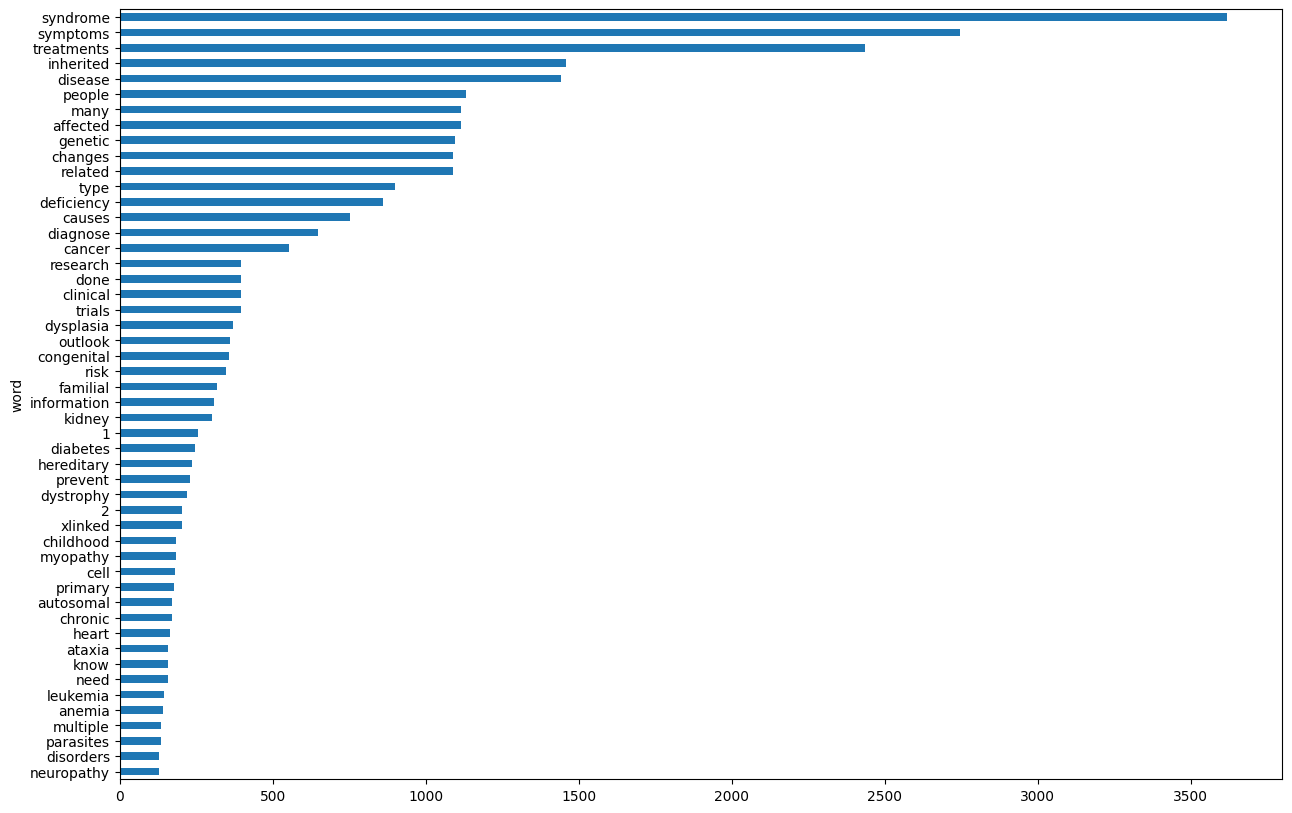

In [50]:
word_counts.head(50).sort_values(by="count").plot(
    kind="barh",
    x="word",
    y="count",
    figsize=(15, 10),
    legend=False,
)

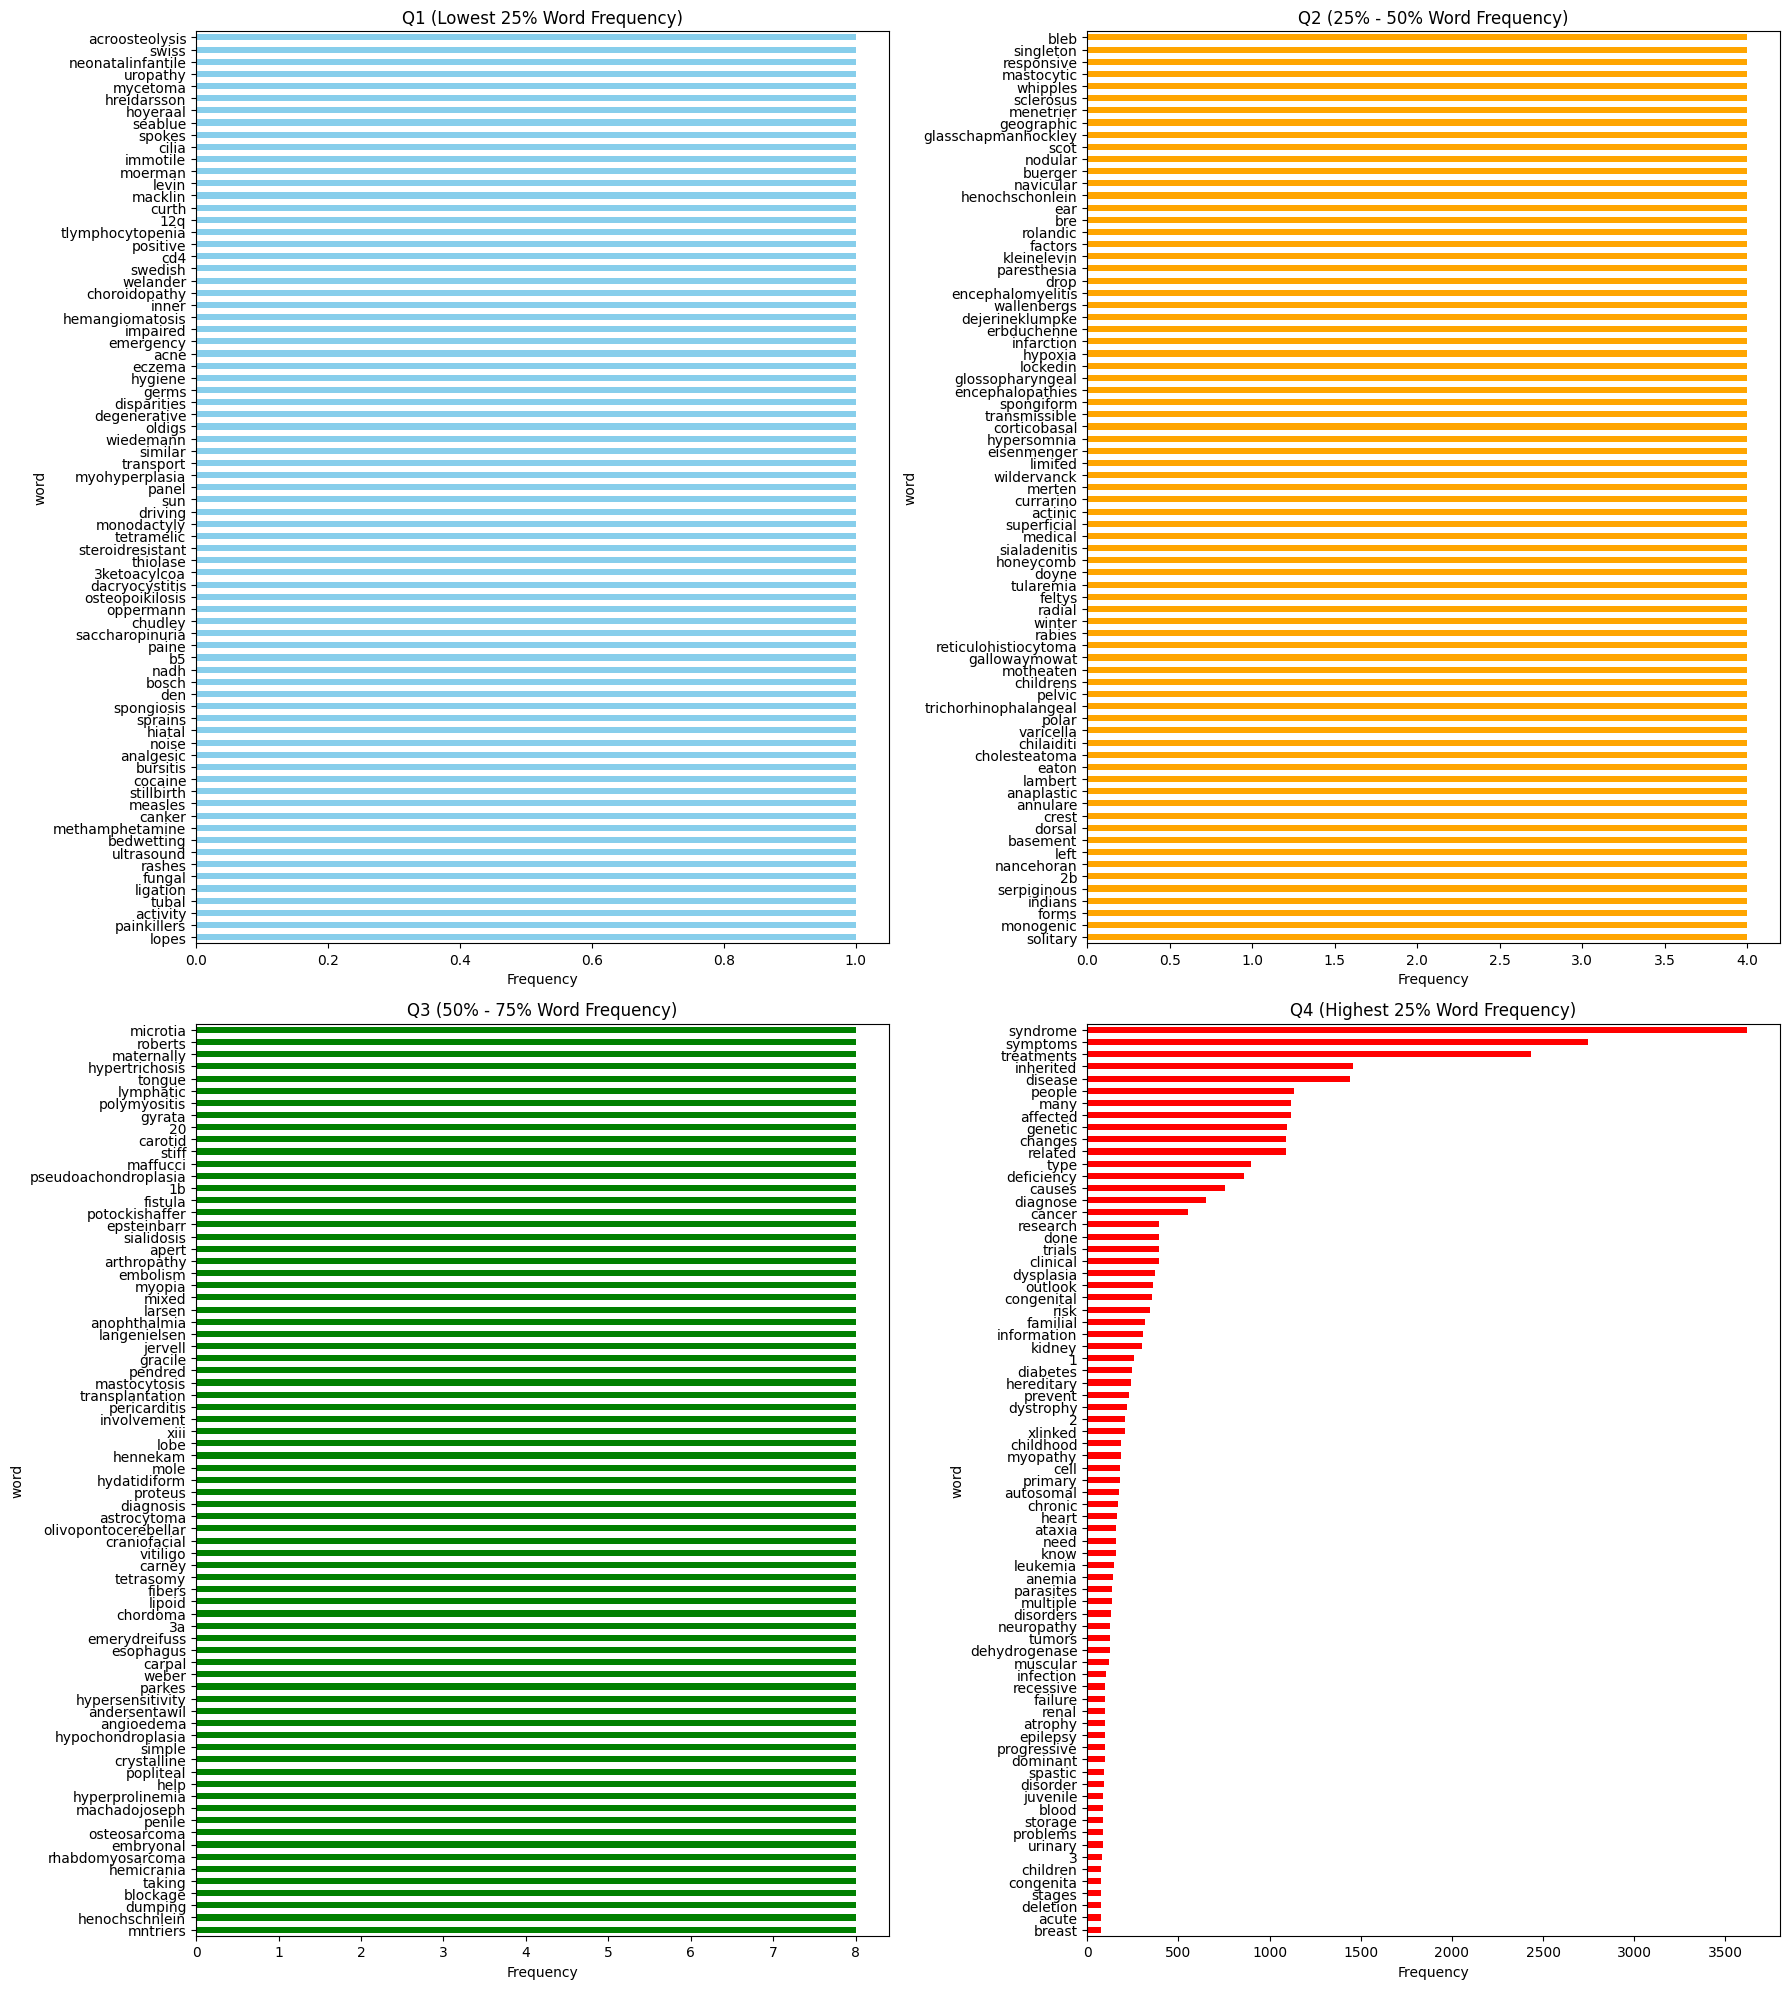

In [51]:
# Sample data for quartile calculation and visualization
quartiles = word_counts["count"].quantile([0.25, 0.5, 0.75]).values

# Separate data into quartile ranges
q1_words = word_counts[word_counts["count"] <= quartiles[0]]
q2_words = word_counts[
    (word_counts["count"] > quartiles[0]) & (word_counts["count"] <= quartiles[1])
]
q3_words = word_counts[
    (word_counts["count"] > quartiles[1]) & (word_counts["count"] <= quartiles[2])
]
q4_words = word_counts[word_counts["count"] > quartiles[2]]

# Plot the quartile distributions
fig, ax = plt.subplots(2, 2, figsize=(18, 20))

# Q1
q1_words.head(75).sort_values(by="count", ascending=True).plot(
    kind="barh", x="word", y="count", ax=ax[0, 0], color="skyblue", legend=False
)
ax[0, 0].set_title("Q1 (Lowest 25% Word Frequency)")
ax[0, 0].set_xlabel("Frequency")

# Q2
q2_words.head(75).sort_values(by="count", ascending=True).plot(
    kind="barh", x="word", y="count", ax=ax[0, 1], color="orange", legend=False
)
ax[0, 1].set_title("Q2 (25% - 50% Word Frequency)")
ax[0, 1].set_xlabel("Frequency")

# Q3
q3_words.head(75).sort_values(by="count", ascending=True).plot(
    kind="barh", x="word", y="count", ax=ax[1, 0], color="green", legend=False
)
ax[1, 0].set_title("Q3 (50% - 75% Word Frequency)")
ax[1, 0].set_xlabel("Frequency")

# Q4
q4_words.head(75).sort_values(by="count", ascending=True).plot(
    kind="barh", x="word", y="count", ax=ax[1, 1], color="red", legend=False
)
ax[1, 1].set_title("Q4 (Highest 25% Word Frequency)")
ax[1, 1].set_xlabel("Frequency")

plt.tight_layout()
plt.show()

### Clustering algorithms + dim reduction

In [53]:
processed_questions = data["question_processed"].apply(lambda x: " ".join(x))

# Create a CountVectorizer object
vectorizer = TfidfVectorizer(use_idf=True, max_features=500)

# Fit and transform the processed questions
X = vectorizer.fit_transform(processed_questions)

# Create a Clustering object
kmeans = KMeans(n_clusters=10, random_state=42)
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the clustering object
kmeans.fit(X.toarray())
dbscan.fit(X.toarray())

# Get the cluster labels
data["cluster_kmeans"] = kmeans.labels_
data["cluster_dbscan"] = dbscan.labels_

# Reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

X_pca = pca.fit_transform(X.toarray())
X_tsne = tsne.fit_transform(X.toarray())

# Create a DataFrame with the reduced data
data_pca = pd.DataFrame(X_pca, columns=["x", "y"])
data_tsne = pd.DataFrame(X_tsne, columns=["x", "y"])

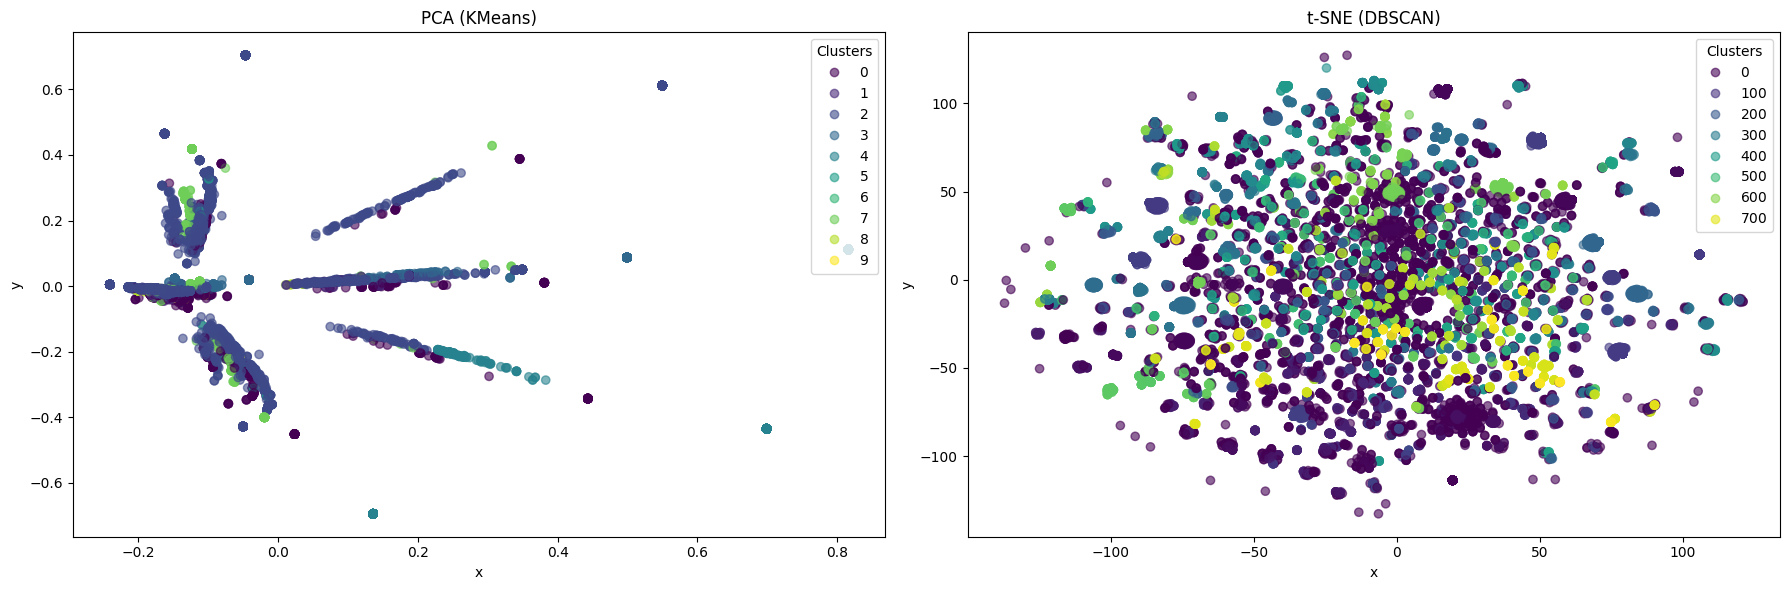

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))


for i, (data_, cluster_col, title) in enumerate(
    zip(
        [data_pca, data_tsne],
        ["cluster_kmeans", "cluster_dbscan"],
        ["PCA (KMeans)", "t-SNE (DBSCAN)"],
    )
):

    scatter = ax[i].scatter(
        data_["x"], data_["y"], c=data[cluster_col], cmap="viridis", alpha=0.6
    )

    ax[i].set_title(title)

    ax[i].set_xlabel("x")

    ax[i].set_ylabel("y")

    if "dbscan" not in cluster_col or (data[cluster_col] != -1).any():

        ax[i].legend(*scatter.legend_elements(), title="Clusters", loc="upper right")


plt.tight_layout()


plt.show()

### Improving encoding with transformers

In [57]:
# Tries:
# - "emilyalsentzer/Bio_ClinicalBERT" -> Testing BioBERT results
# - "allMiniLM-L6-v2"
# - "ncbi/MedCPT-Article-Encoder"

model = SentenceTransformer("emilyalsentzer/Bio_ClinicalBERT")
X = model.encode(data["question"] + " " + data["answer"])

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: emilyalsentzer/Bio_ClinicalBERT


Batches:   0%|          | 0/513 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [58]:
# new kmeans
kmeans = KMeans(n_clusters=20, random_state=42)

# Fit the clustering object
kmeans.fit(X)

# Get the cluster labels
data["cluster_kmeans"] = kmeans.labels_

# pca
pca = PCA(n_components=3)

X_pca = pca.fit_transform(X)

data_pca = pd.DataFrame(X_pca, columns=["x", "y", "z"])

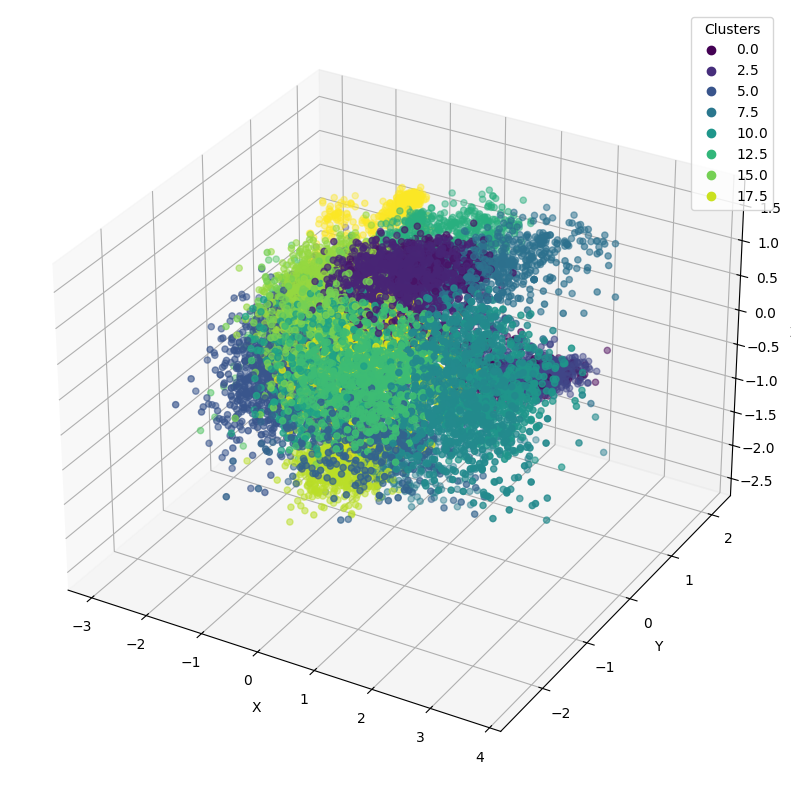

In [59]:
# 3d plot

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    data_pca["x"],
    data_pca["y"],
    data_pca["z"],
    c=data["cluster_kmeans"],
    cmap="viridis",
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")

plt.show()